# Showcase for ptdalgorithms

Python header:

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

def plot_graph(gam, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    
    states, sim, ipv = np.array(gam[0]), np.array(gam[1]), np.array(gam[2])

    states = np.array(states)
    states = np.append(states, np.array([[9]*states.shape[1]]), axis=0)

    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]
    
    dot = Digraph()
    dot.node('Start', 'Start')
    dot.node(str(len(states)-1), 'Absorbing')    
    for i in range(0, len(states)-1):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('Start', str(i), constraint=constrained, label=str(ipv[i]))
    for i in range(len(states)):
        for j in range(len(states)):
            if i != j and rates[i, j] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i, j]))
    dot.graph_attr['size'] = size                
    return dot


R header:

In [2]:
%%R
#library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

R[write to console]: Indlæser krævet pakke: usethis

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (29809aeb) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# %%R
# remove.packages("ptdalgorithms")

In [4]:
# %%R
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:

# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:

# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
%%R
Rcpp::sourceCpp("./coalescent.cpp")

ld: warning: directory not found for option '-L/Users/runner/miniforge3/conda-bld/r-base-split_1642327617770/_build_env/lib'
ld: warning: -pie being ignored. It is only used when linking a main executable


In [25]:
%%R
graph <- construct_coalescent_selection_graph(4, 0, 20, 10, 0)
vertices_length(graph)

[1] 51


bin 1
bin 3
bin 5
bin 7
bin 9
bin 11
bin 13
bin 15
bin 17
bin 19


In [24]:
%%R
expectation(graph)

[1] 1.5


INFO: building reward compute graph...


In [13]:
%%R -o gam
gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 21


In [14]:
%%R
x <- gam$IPV / sum(gam$IPV)


In [15]:
%%R
gam$IPV

 [1] 4.916863e-35 1.348438e-05 0.000000e+00 9.998364e-01 1.500751e-04
 [6] 1.909227e-15 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
[11] 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00


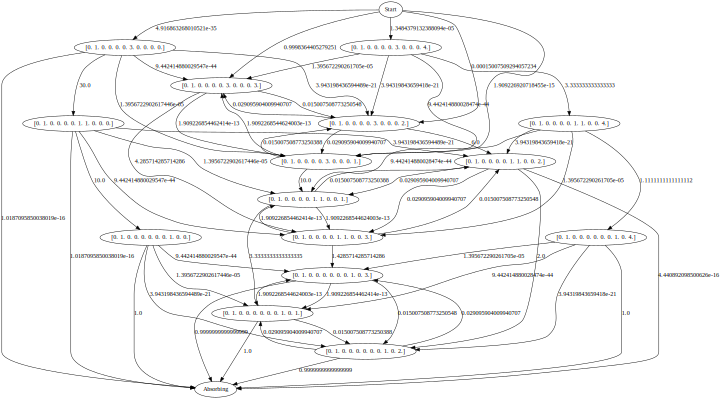

In [16]:
plot_graph(gam)

## Standard coalescent

If you already have the subintensity matrix and initial probability vector:

In [86]:
%%R -o sim -o ipv
sim = matrix(c(-6, 6, 0, 0, 
               0, -3, 1, 2,
               0, 0, -1, 0,
               0, 0, 0, -1), nrow=4, ncol=4, byrow = TRUE)
ipv = c(1, 0, 0, 0)
sim

     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1


In [4]:
%%R 
graph <- matrix_as_graph(ipv, sim)

Note that the state vectors are ofcause undefined (all zero) when constructing the graph this way:

In [5]:
%%R
graph_as_matrix(graph)

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



In [6]:
%%R
dph(0.9, graph)

[1] 0.5362689


If you want to generate the state space:

In [7]:
%%R -o gam -o n -o graph
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate, c(rate)
        )
    }
  }
      
  index <- index + 1
}

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6


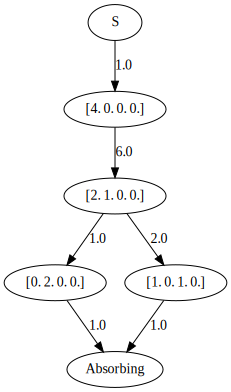

In [8]:
plot_graph(gam)

As matrices:

In [9]:
%%R -o states -o sim
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

$states
     [,1] [,2] [,3] [,4]
[1,]    4    0    0    0
[2,]    2    1    0    0
[3,]    0    2    0    0
[4,]    1    0    1    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



Invert subintensity matrix to get Green matrix:

In [10]:
%%R
U <- -solve(matrices$SIM)
U

          [,1]      [,2]      [,3]      [,4]
[1,] 0.1666667 0.3333333 0.3333333 0.6666667
[2,] 0.0000000 0.3333333 0.3333333 0.6666667
[3,] 0.0000000 0.0000000 1.0000000 0.0000000
[4,] 0.0000000 0.0000000 0.0000000 1.0000000


Compute expectation from matrices:

In [11]:
%%R
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

     [,1]
[1,]  1.5


Compute moments:

In [47]:
%%R
expectation(graph)

[1] 6


INFO: building reward compute graph...


In [13]:
%%R
expected_waiting_time(graph)

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000


In [14]:
%%R
variance(graph)

[1] 1.138889


In [15]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 1.138889 1.138889 1.111111 1.000000 1.000000 0.000000


In [16]:
%%R
moments(graph, 4)

[1]  1.500000  3.388889 10.583333 42.907407


Marginal expectations using rewards:

In [17]:
%%R
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    4    2    0    1    0
[2,]    0    0    1    2    0    0
[3,]    0    0    0    0    1    0
[4,]    0    0    0    0    0    1


Rows happens to be our reward vectors. E.g. singleton rewards:

In [18]:
%%R
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
singletons <- rewards[1,]
doubletons <- rewards[2,]
tripletons <- rewards[3,]
singletons

[1] 0 4 2 0 1 0


Expected tripleton branch length:

In [19]:
%%R
expectation(graph, tripletons)

[1] 0.6666667


SFS:

In [20]:
%%R -o sfs
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
sfs

[1] 2.0000000 1.0000000 0.6666667


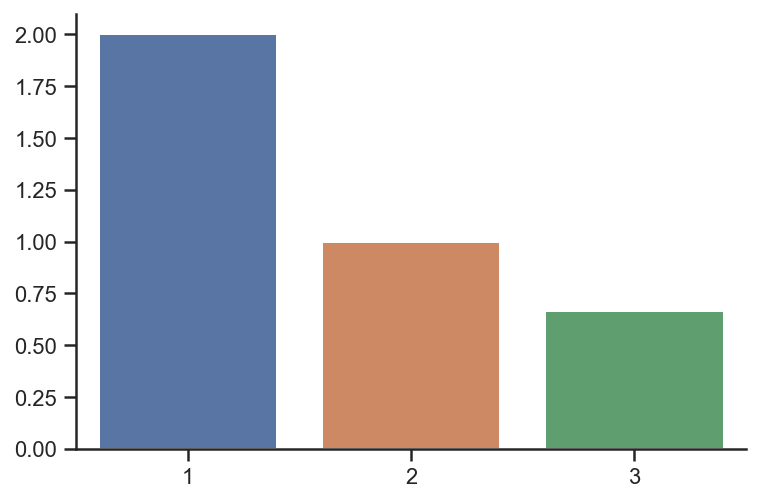

In [21]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

Covariance:

In [22]:
%%R
covariance(graph, singletons, doubletons)

[1] -0.2222222


In [23]:
%%R
covariance(graph, singletons, tripletons)

[1] 0.8888889


Covariane between "ton" branch length:

In [24]:
%%R -o cov_mat
cov_mat <- matrix(nrow=n-1,ncol=n-1)

for (i in 1:(n-1)) {
    for (j in 1:(n-1)) {
        cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
    }
}

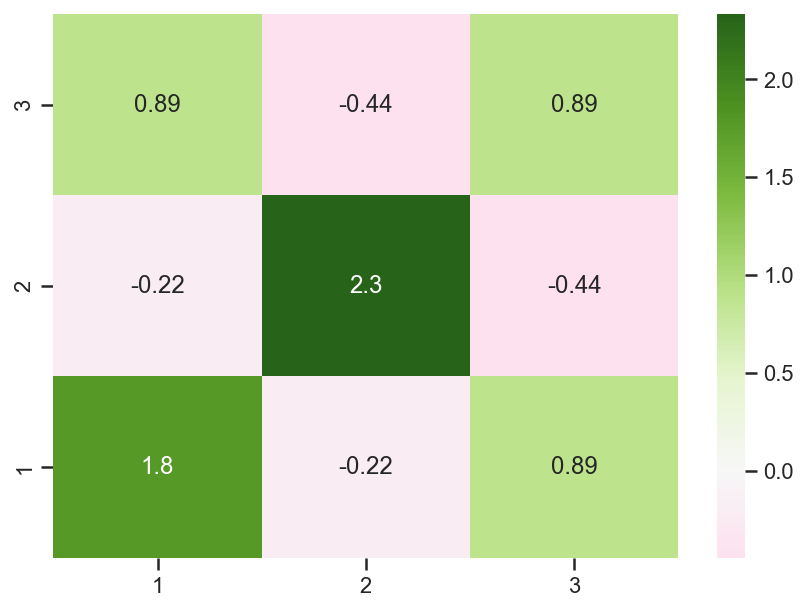

In [25]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(n)))
ax = sns.heatmap(cov_mat, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

Distributions of each "ton" branch length:

In [26]:
%%R -o result

result = data.frame()
for (i in 1:(dim(rewards)[1]-1)) {
    x <- seq(from = 0, to = 4, by = 0.01)
    pdf <- dph(x, reward_transform(graph, rewards[i, ]))
    df <- data.frame(prob = pdf, t=x, ton=i)
    result <- rbind(result, df)
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

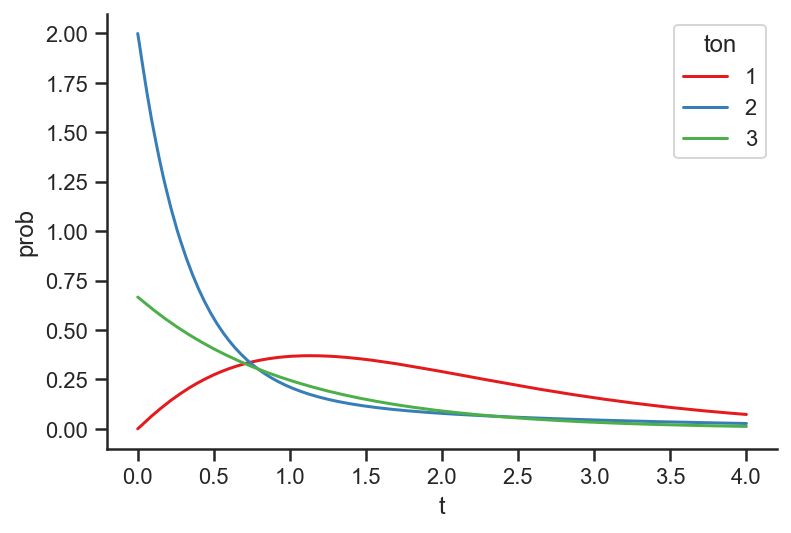

In [27]:
sns.lineplot(data=result, y='prob', x='t', hue='ton', palette='Set1')
sns.despine()

Compute expectations from the distributions:

In [28]:
%%R -o sfs
ctx <- distribution_context(graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))
sfs

[1] 1.9993341 0.9993341 0.6660008


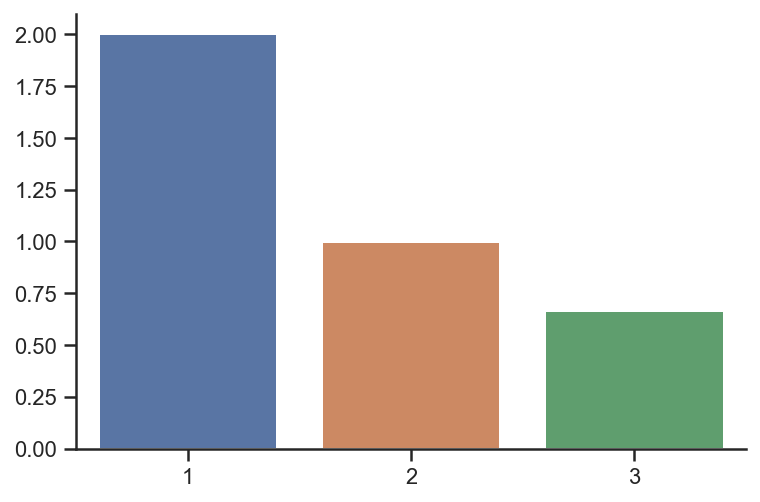

In [29]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

Changing rates (edge weights) using parametrization:

In [30]:
%%R -o gam

graph_update_weights_parameterized(graph, c(2))

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM
gam <- graph_as_matrix(graph)

Change rates back to normal:

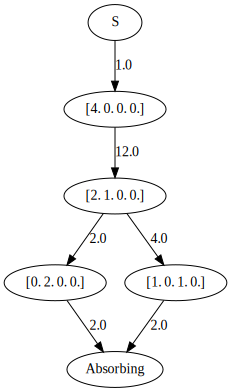

In [31]:
plot_graph(gam)

In [32]:
%%R -o gam

graph_update_weights_parameterized(graph, c(1))

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

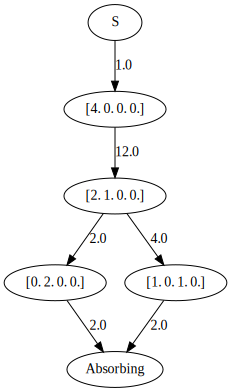

In [33]:
plot_graph(gam)

## Time-inhomgeneous coalescent

The distribution context is always made on the graph without rewards transformation. You can then:

- Get the distribution (and from that all moments) of time to absorbtion. Note that you cannot use dph for this as this assumes the current edge-weights and not seqentially updated ones in the distribution context.
- Get the marginal exepectations by summing over the products of the expected accumulated visiting times and rewards.


In [34]:
%%R -o cdf1 -o cdf2 -o cdf3

cdf_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$cdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }

    return(data.frame(prob = unlist(tmrca_pdf), t=unlist(time)))

}

epoques = c(0, 1, 2, 3, 4)
cdf1 <- cdf_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
cdf2 <- cdf_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
cdf3 <- cdf_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

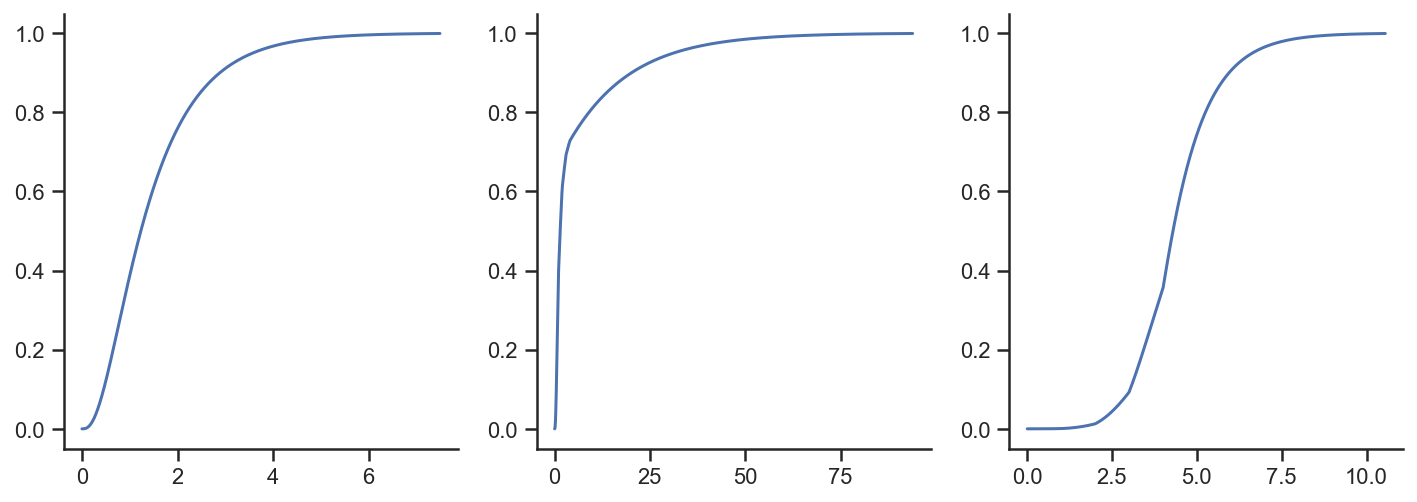

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(cdf1.t, cdf1.prob)
axes[1].plot(cdf2.t, cdf2.prob)
axes[2].plot(cdf3.t, cdf3.prob)
sns.despine()

In [36]:
%%R -o sfs1 -o sfs2 -o sfs3

sfs_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        # tmrca_pdf <- c(tmrca_pdf, distribution_context_state(ctx)$pdf)
        # time <- c(time, distribution_context_state(ctx)$time)
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }
    expected_visits <- distribution_context_accumulated_visiting_time(ctx)
    
    sfs <- c()
    for (i in 1:(dim(rewards)[1]-1)) {
        sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
    }
    return(sfs)
}

epoques = c(0, 1, 2, 3, 4)
sfs1 <- sfs_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
sfs2 <- sfs_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
sfs3 <- sfs_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

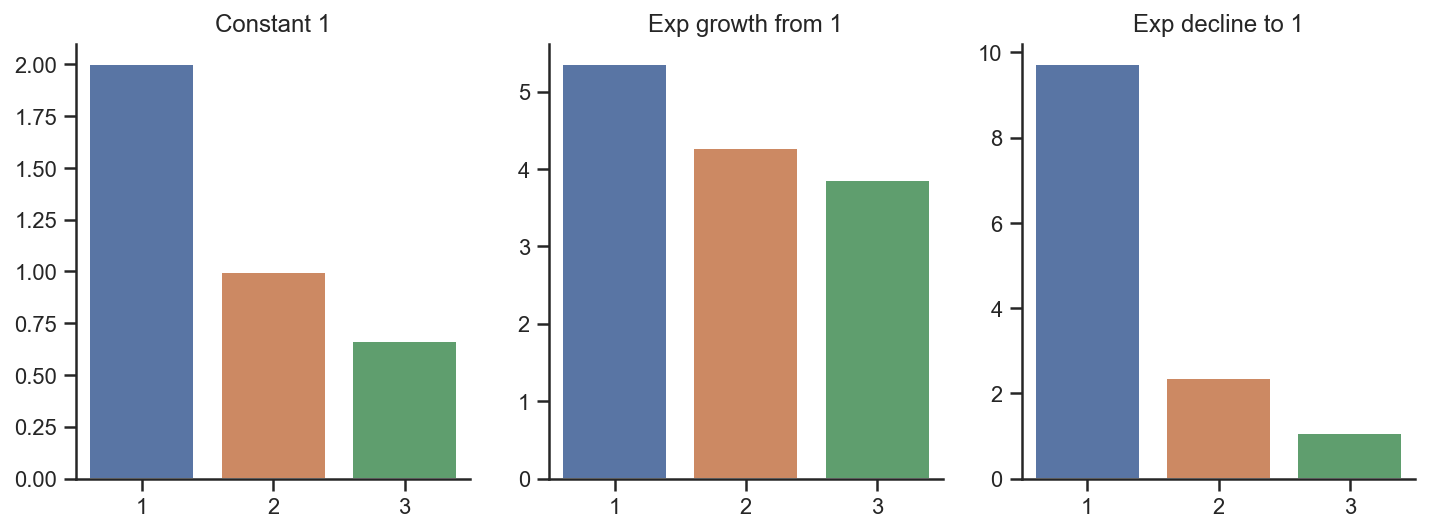

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.barplot(x=list(range(1, len(sfs1)+1)), y=sfs1, ax=axes[0]).set_title("Constant 1")
sns.barplot(x=list(range(1, len(sfs2)+1)), y=sfs2, ax=axes[1]).set_title("Exp growth from 1")
sns.barplot(x=list(range(1, len(sfs3)+1)), y=sfs3, ax=axes[2]).set_title("Exp decline to 1")
sns.despine()

# Discrete phase-type distribution

First build representation of the continuous phase-type distribution for the coalescent:

In [38]:
%%R -o n -o gam
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate
        )
    }
  }
      
  index <- index + 1
}

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6


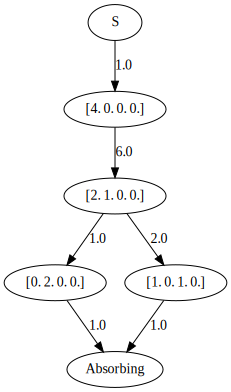

In [39]:
plot_graph(gam)

Then turn it into a descrete phase-type distribution:

In [52]:
%%R -o gam

make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# self-transition rate:
mutation_rate <- 1

# clone graph to get one to modify:
mutation_graph <- clone_graph(graph)

# add auxilliary states, normalize and return reward matrix:
rewards <- make_discrete(mutation_graph, mutation_rate)

# for plotting the new graph
gam <- graph_as_matrix(mutation_graph)

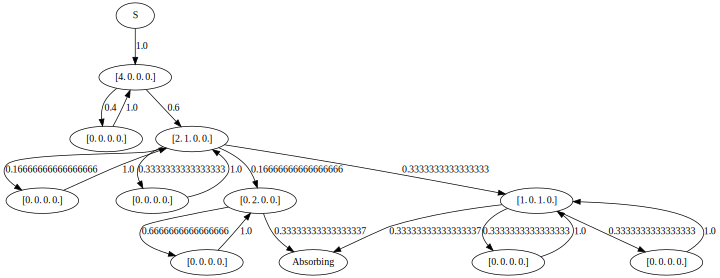

In [41]:
plot_graph(gam)

In [53]:
%%R
sfs <- sapply(1:(n-1), function(i) expectation(mutation_graph, rewards[i,]))
sfs

[1] 2.0000000 1.0000000 0.6666667


INFO: building reward compute graph...


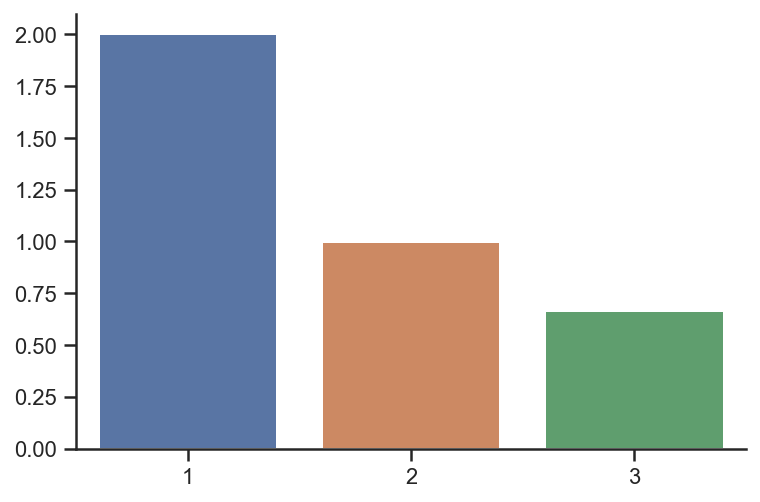

In [54]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

Covariance:

In [47]:
%%R
covariance(mutation_graph, rewards[1,], rewards[2,])

[1] -0.2222222


In [55]:
%%R
covariance(mutation_graph, rewards[1,], rewards[3,])

[1] 0.8888889


Covariane between "ton" branch length:

In [56]:
%%R -o cov_mat
cov_mat <- matrix(nrow=n-1,ncol=n-1)

for (i in 1:(n-1)) {
    for (j in 1:(n-1)) {
        cov_mat[i, j] <- covariance(mutation_graph, rewards[i,], rewards[j,])
    }
}

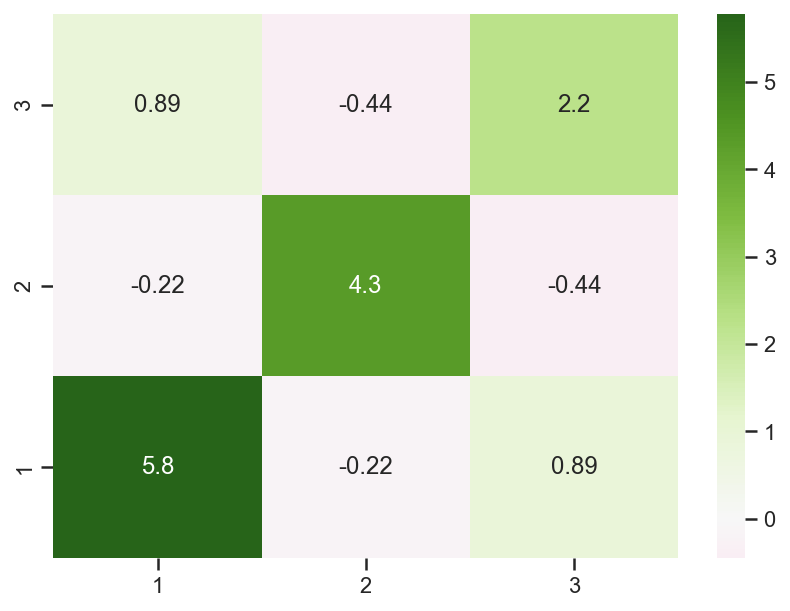

In [57]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(n)))
ax = sns.heatmap(cov_mat, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

In the discrete version, the covariances between tons are the same, but the variance with the same ton between loci (diagonal) is different. The reason must be that the ton variance is much bigger in the discrete version, and the between-locus same-ton variance is almost the same as the ton variance. But still, the part covaries is the same. 

Distributions of each "ton":

In [68]:
%%R -o result

result = data.frame()
for (i in 1:(dim(rewards)[1]-1)) {
    x <- seq(from = 0, to = 4, by = 0.01)
    pdf <- dph(x, reward_transform(mutation_graph, rewards[i, ]))
    df <- data.frame(prob = pdf, t=x, ton=i)
    result <- rbind(result, df)
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

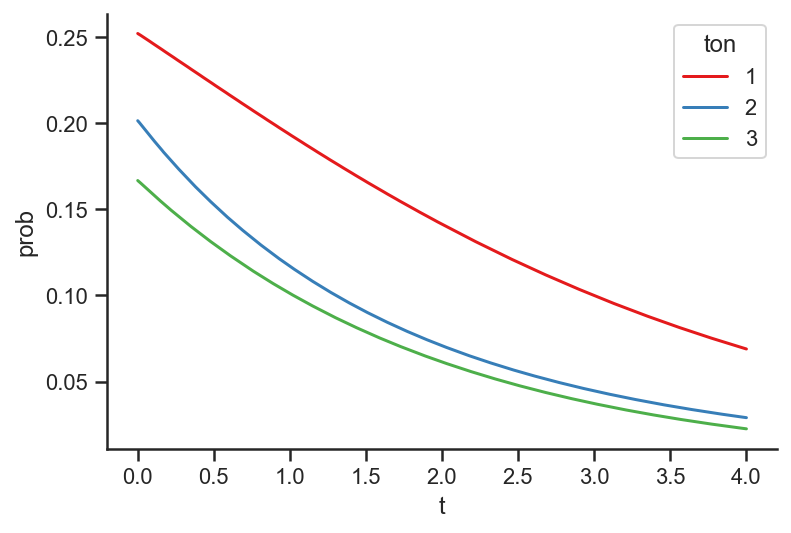

In [69]:
sns.lineplot(data=result, y='prob', x='t', hue='ton', palette='Set1')
sns.despine()

Compute expectations from the distributions:

In [62]:
%%R -o sfs
ctx <- distribution_context(mutation_graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))
sfs

[1] 1.9991789 0.9991819 0.6658514


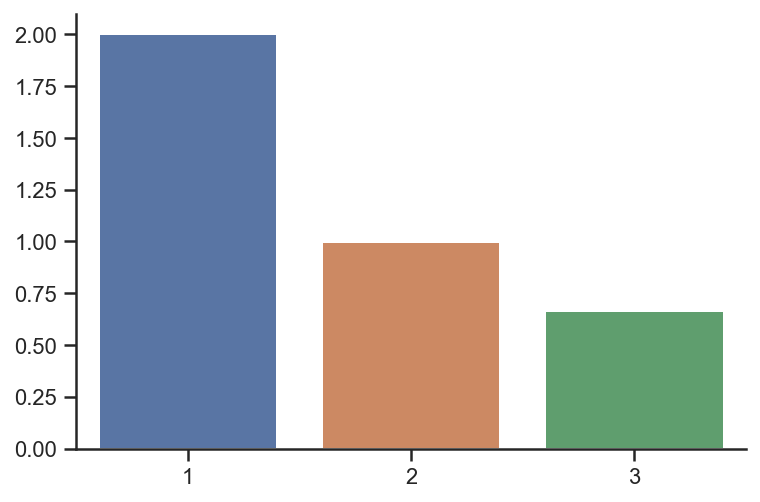

In [63]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()